In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
from pandas_ta.momentum import rsi
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
import scipy 
from scipy import stats 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import math
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

def get_price(ticker, start_date, end_date):
    """Return a DataFrame with price information (open, high, low, close, adjusted close, and volume) for the ticker between the specified dates."""
    df = yf.download(ticker, start_date, end_date, progress=False)
    df.reset_index(inplace=True)

    return df# 

def get_closed_dates(df):
    """Return a list containing all dates on which the stock market was closed."""
    # Create a dataframe that contains all dates from the start until today.
    timeline = pd.date_range(start=df['Date'].iloc[0], end=df['Date'].iloc[-1])

    # Create a list of the dates existing in the dataframe.
    df_dates = [day.strftime('%Y-%m-%d') for day in pd.to_datetime(df['Date'])]

    # Finally, determine which dates from the 'timeline' do not exist in our dataframe.
    closed_dates = [
        day for day in timeline.strftime('%Y-%m-%d').tolist()
        if not day in df_dates
    ]

    return closed_dates


def get_RSI(df, column, time_window):
    """Return the RSI indicator for the specified time window."""
    diff = df[column].diff(1)

    # This preservers dimensions off diff values.
    up_chg = 0 * diff
    down_chg = 0 * diff

    # Up change is equal to the positive difference, otherwise equal to zero.
    up_chg[diff > 0] = diff[diff > 0]

    # Down change is equal to negative deifference, otherwise equal to zero.
    down_chg[diff < 0] = diff[diff < 0]

    # We set com = time_window-1 so we get decay alpha=1/time_window.
    up_chg_avg = up_chg.ewm(com=time_window - 1,
                            min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window - 1,
                                min_periods=time_window).mean()

    RS = abs(up_chg_avg / down_chg_avg)
    df['RSI'] = 100 - 100 / (1 + RS)
    # df = df[['RSI']]
    return df

def get_MACD(df, column='Adj Close'):
    """Return a new DataFrame with the MACD and related information (signal line and histogram)."""
    df['EMA-12'] = df[column].ewm(span=12, adjust=False).mean()
    df['EMA-26'] = df[column].ewm(span=26, adjust=False).mean()

    # MACD Indicator = 12-Period EMA − 26-Period EMA.
    df['MACD'] = df['EMA-12'] - df['EMA-26']

    # Signal line = 9-day EMA of the MACD line.
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Histogram = MACD - Indicator.
    df['Histogram'] = df['MACD'] - df['Signal']

    return df


def plot_volume(fig, df, row, column=1):
    """Return a graph object figure containing the volume chart in the specified row."""
    fig.add_trace(go.Bar(x=df['Date'],
                         y=df['Volume'],
                         marker=dict(color='lightskyblue',
                                     line=dict(color='firebrick', width=0.1)),
                         showlegend=False,
                         name='Volume'),
                  row=row,
                  col=column)

    fig.update_xaxes(title_text='Date', row=row, col=column)
    fig.update_yaxes(title_text='Volume ($)', row=row, col=column)

    return fig

def plot_candlestick_chart(fig, df, row, column=1, plot_EMAs=True, plot_strategy=True):
    """Return a graph object figure containing a Candlestick chart in the specified row."""
    fig.add_trace(go.Candlestick(x=df['Date'],
                                 open=df['Open'],
                                 high=df['High'],
                                 low=df['Low'],
                                 close=df['Close'],
                                 name='Candlestick Chart'),
                  row=row,
                  col=column)

    # If the boolean argument plot_EMAs is True, then show the line plots for the two exponential moving averages.
    if (plot_EMAs == True):
        fig.add_trace(go.Scatter(x=df['Date'],
                                 y=df['EMA-12'],
                                 name='12-period EMA',
                                 line=dict(color='dodgerblue', width=2)),
                      row=row,
                      col=column)

        fig.add_trace(go.Scatter(x=df['Date'],
                                 y=df['EMA-26'],
                                 name='26-period EMA',
                                 line=dict(color='whitesmoke', width=2)),
                      row=row,
                      col=column)

    if (plot_strategy == True):
        fig.add_trace(go.Scatter(x=df['Date'],
                                 y=df['Buy'],
                                 name='Buy Signal',
                                 mode='markers',
                                 marker_symbol='triangle-up',
                                 marker=dict(size=9),
                                 line=dict(color='Lime')),
                      row=row,
                      col=column)

        fig.add_trace(go.Scatter(x=df['Date'],
                                 y=df['Sell'],
                                 name='Sell Signal',
                                 mode='markers',
                                 marker_symbol='triangle-down',
                                 marker=dict(size=9, color='Yellow')),
                      row=row,
                      col=column)

    fig.update_xaxes(rangeslider={'visible': False})
    fig.update_yaxes(title_text='Price ($)', row=row, col=column)

    return fig


def plot_MACD(fig, df, row, column=1):
    """Return a graph object figure containing the MACD indicator, the signal line, and a histogram in the specified row."""
    df['Hist-Color'] = np.where(df['Histogram'] < 0, 'red', 'green')
    fig.add_trace(go.Bar(x=df['Date'],
                         y=df['Histogram'],
                         name='Histogram',
                         marker_color=df['Hist-Color'],
                         showlegend=True),
                  row=row,
                  col=column)

    fig.add_trace(go.Scatter(x=df['Date'],
                             y=df['MACD'],
                             name='MACD',
                             line=dict(color='darkorange', width=2)),
                  row=row,
                  col=column)

    fig.add_trace(go.Scatter(x=df['Date'],
                             y=df['Signal'],
                             name='Signal',
                             line=dict(color='cyan', width=2)),
                  row=row,
                  col=column)

    fig.update_yaxes(title_text='MACD', row=row, col=column)

    return fig


def plot_RSI(fig, df, row, column=1):
    """Return a graph object figure containing the RSI indicator in the specified row."""
    fig.add_trace(go.Scatter(x=df['Date'].iloc[30:],
                             y=df['RSI'].iloc[30:],
                             name='RSI',
                             line=dict(color='gold', width=2)),
                  row=row,
                  col=column)

    fig.update_yaxes(title_text='RSI', row=row, col=column)

    # Add one red horizontal line at 70% (overvalued) and green line at 30% (undervalued)
    for y_pos, color in zip([70, 30], ['Red', 'Green']):
        fig.add_shape(x0=df['Date'].iloc[1],
                      x1=df['Date'].iloc[-1],
                      y0=y_pos,
                      y1=y_pos,
                      type='line',
                      line=dict(color=color, width=2),
                      row=row,
                      col=column)

    # Add a text box for each line
    for y_pos, text, color in zip([64, 36], ['Overvalued', 'Undervalued'], ['Red', 'Green']):
        fig.add_annotation(x=df['Date'].iloc[int(df['Date'].shape[0] / 10)],
                           y=y_pos,
                           text=text,
                           font=dict(size=14, color=color),
                           bordercolor=color,
                           borderwidth=1,
                           borderpad=2,
                           bgcolor='lightsteelblue',
                           opacity=0.75,
                           showarrow=False,
                           row=row,
                           col=column)

    # Update the y-axis limits
    ymin = 25 if df['RSI'].iloc[30:].min() > 25 else df['RSI'].iloc[30:].min() - 5
    ymax = 75 if df['RSI'].iloc[30:].max() < 75 else df['RSI'].iloc[30:].max() + 5
    fig.update_yaxes(range=[ymin, ymax], row=row, col=column)

    return fig


1. DOWNLOAD DATA

In [29]:
ticker = 'CL=F'
no_years = 100

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() -
              datetime.timedelta(days=no_years * 365)).strftime('%Y-%m-%d')

print('Ticker: {}'.format(ticker))
print('Start Date: ', start_date)
print('End Date: ', end_date)

df = get_price(ticker, start_date, end_date)
closed_dates_list = get_closed_dates(df)

df['Year'] = df['Date'].astype(str).str[0:4].astype(int)
df['Month'] = df['Date'].astype(str).str[5:7].astype(int)
df['Day'] = df['Date'].astype(str).str[8:10].astype(int)

df


Ticker: CL=F
Start Date:  1924-06-13
End Date:  2024-05-19


,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
0,2000-08-23,31.950001,32.799999,31.950001,32.049999,32.049999,79385,2000,8,23
1,2000-08-24,31.900000,32.240002,31.400000,31.629999,31.629999,72978,2000,8,24
2,2000-08-25,31.700001,32.099998,31.320000,32.049999,32.049999,44601,2000,8,25
3,2000-08-28,32.040001,32.919998,31.860001,32.869999,32.869999,46770,2000,8,28
4,2000-08-29,32.820000,33.029999,32.560001,32.720001,32.720001,49131,2000,8,29
...,...,...,...,...,...,...,...,...,...,...
5955,2024-05-13,78.180000,79.489998,77.779999,79.120003,79.120003,287701,2024,5,13
5956,2024-05-14,79.230003,79.379997,77.680000,78.019997,78.019997,307410,2024,5,14
5957,2024-05-15,78.440002,78.919998,76.699997,78.629997,78.629997,321267,2024,5,15
5958,2024-05-16,78.839996,79.849998,78.199997,79.230003,79.230003,230277,2024,5,16


2. CALCULATE EMA AND RSI AND EVALUATE SIGNALS

1
1


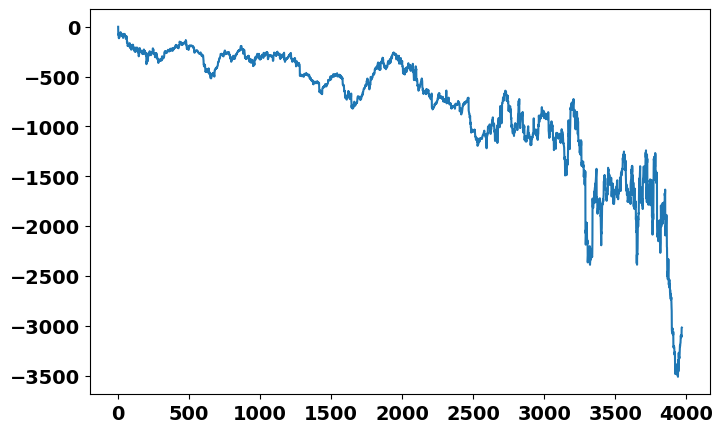

In [30]:
if True:
    d = pd.DataFrame(index = [0],columns=['shortTermEMA','longTermEMA','rsiLength','priceDistanceLong','priceDistanceShort','longRSI','shortRSI','RiskReturn','HitRate',"Return","NumOps","Std","Slope"])
    d.to_csv('StrategyBackTest_NQ30.csv') 

    # shortTermEMA = list(np.arange(8,11,1))
    # longTermEMA = list(np.arange(40,200,5))
    # rsiLength = list(np.arange(7,10,1))
    # priceDistanceLong = list(np.arange(-0.5,-2.5,-0.5))
    # priceDistanceShort = list(np.arange(0.5,2.5,0.5))
    # longRSI = [38.2]
    # shortRSI = [61.8]

    # shortTermEMA = [8]
    # longTermEMA = [45]
    # rsiLength = [7]
    # priceDistanceLong = [-2]
    # priceDistanceShort = [1.5]
    # longRSI = [38.2]
    # shortRSI = [61.8]


    print(len(shortTermEMA) * len(longTermEMA) * len(rsiLength) * len(priceDistanceLong) * len(priceDistanceShort) * len(shortRSI) * len(longRSI))



    iCount = 0
    for iiii in range(len(shortTermEMA)):
        for jjjj in range(len(longTermEMA)):
            for kk in range(len(rsiLength)):
                    for ll in range(len(priceDistanceLong)):
                        for mm in range(len(priceDistanceShort)):
                            for nn in range(len(longRSI)):
                                for oo in range(len(shortRSI)):
                                    iCount += 1
                                    if((iCount < 10) | (iCount%2000 == 0)):
                                        print(iCount)
                                    #df = get_price(ticker, start_date, end_date)
                                    df = pd.read_csv("NQ_full_30min_continuous_UNadjusted.txt")
                                    df['Adj Close'] = df['Close']
                                    df['EMA'+str(shortTermEMA[iiii])] = df['Adj Close'].ewm(span=shortTermEMA[iiii], adjust=False).mean()
                                    df['EMA'+str(longTermEMA[jjjj])] = df['Adj Close'].ewm(span=longTermEMA[jjjj], adjust=False).mean()
                                    get_RSI(df,'Adj Close',rsiLength[kk])
                                    df.dropna(inplace=True)
                                    bins = [0,20,25,30,33,50,55,60,64,75,100]

                                    df['RSI_binned'] = pd.cut(df['RSI'], bins)

                                    df['crossEMA'] = np.where(
                                                            ((df['EMA'+str(shortTermEMA[iiii])].shift(1) < df['EMA'+str(longTermEMA[jjjj])].shift(1)) & 
                                                            (df['EMA'+str(shortTermEMA[iiii])] > df['EMA'+str(longTermEMA[jjjj])])),1,
                                                            np.where((df['EMA'+str(shortTermEMA[iiii])].shift(1) > df['EMA'+str(longTermEMA[jjjj])].shift(1)) & 
                                                            (df['EMA'+str(shortTermEMA[iiii])] < df['EMA'+str(longTermEMA[jjjj])]),-1,0)
                                                            )

                                    df['Exit'] = np.where(((df['High'].shift(1) < df['EMA'+str(shortTermEMA[iiii])].shift(1)) & 
                                                            (df['High'] > df['EMA'+str(shortTermEMA[iiii])])),"ExitLong",
                                                            np.where((df['Low'].shift(1) > df['EMA'+str(shortTermEMA[iiii])].shift(1)) & 
                                                            (df['Low'] < df['EMA'+str(shortTermEMA[iiii])]),"ExitShort",0)
                                                            )

                                    df['PriceDistance'] = np.where( 
                                                                    df['crossEMA'] != 0, ((df['Adj Close'] / df['EMA'+str(shortTermEMA[iiii])])-1)*100,0
                                                                    )

                                    binsPrice = [-99999,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,99999]

                                    df['Price_binned'] = pd.cut(df['PriceDistance'], binsPrice)

                                    def predSignal(row):
                                        if((row['crossEMA'] == -1) & (row['PriceDistance'] > priceDistanceLong[ll]) & (row['RSI'] <= longRSI[nn])):
                                            return 1
                                        elif((row['crossEMA'] == 1) & (row['PriceDistance'] < priceDistanceShort[mm]) & (row['RSI'] >= shortRSI[oo])):
                                            return -1
                                        else:
                                            return 0

                                    df['predSignal'] = df.apply(predSignal, axis=1)
                                    dev = df

                                    spread = (0.0001)/2
                                                                        
                                                
                                    signal = np.array(dev['predSignal'])
                                
                                    openLongPrice = []
                                    stopLossLong = []
                                    takeProfilLong = []
                                    exitLongPosition = []
                                    PnL_Long = []
                                    exitPriceL = []
                                    keepOpenLongPosition = []
                                    signal = np.array(dev['predSignal'])
                                    openPr = np.array(dev['Open'])
                                    low = np.array(dev['Low'])
                                    high = np.array(dev['High'])
                                    close = np.array(dev['Close'])
                                    exitP = np.array(dev['Exit'])
                                    
                                    for i in range(len(dev)):
                                        openLongPrice.append(0)
                                        stopLossLong.append(0)
                                        takeProfilLong.append(0)
                                        exitLongPosition.append(0)
                                        exitPriceL.append(0)
                                        PnL_Long.append(0)
                                        keepOpenLongPosition.append(0)
                                        if(signal[i-1] == 1 and exitLongPosition[i-1] == 0 and keepOpenLongPosition[i-1] == 0):
                                            openLongPrice[i] = openPr[i]*(1+spread)
                                            if(exitP[i] == "ExitLong"):
                                                exitPriceL[i] = close[i]*(1-spread)
                                                exitLongPosition[i] = 1
                                                PnL_Long[i] = exitPriceL[i]-openLongPrice[i]
                                                keepOpenLongPosition[i] = 0
                                            else:
                                                exitPriceL[i] = 0
                                                exitLongPosition[i] = 0
                                                PnL_Long[i] = 0
                                                keepOpenLongPosition[i] = 1
                                                
                                        elif(signal[i] != -1 and keepOpenLongPosition[i-1] == 1):
                                            openLongPrice[i] = openLongPrice[i-1]
                                            if(exitP[i] == "ExitLong"):
                                                exitPriceL[i] = close[i]*(1-spread)
                                                exitLongPosition[i] = 1
                                                PnL_Long[i] = exitPriceL[i]-openLongPrice[i]
                                                keepOpenLongPosition[i] = 0
                                            else:
                                                exitPriceL[i] = 0
                                                exitLongPosition[i] = 0
                                                PnL_Long[i] = 0
                                                keepOpenLongPosition[i] = 1
                            
                                        elif(signal[i] == -1 and keepOpenLongPosition[i-1] == 1):
                                            openLongPrice[i] = openLongPrice[i-1]
                                            if(exitP[i] == "ExitLong"):
                                                exitPriceL[i] = close[i]*(1-spread)
                                                exitLongPosition[i] = 1
                                                PnL_Long[i] = exitPriceL[i]-openLongPrice[i]
                                                keepOpenLongPosition[i] = 0
                                            else:
                                                exitPriceL[i] = 0
                                                exitLongPosition[i] = 0
                                                PnL_Long[i] = 0
                                                keepOpenLongPosition[i] = 1
                            
                                        elif(signal[i-1] == 1 and keepOpenLongPosition[i-1] == 0 and exitLongPosition[i-1] == 1):
                                            openLongPrice[i] = openPr[i]*(1+spread)
                                            if(exitP[i] == "ExitLong"):
                                                exitPriceL[i] = close[i]*(1-spread)
                                                exitLongPosition[i] = 1
                                                PnL_Long[i] = exitPriceL[i]-openLongPrice[i]
                                                keepOpenLongPosition[i] = 0
                                            else:
                                                exitPriceL[i] = 0
                                                exitLongPosition[i] = 0
                                                PnL_Long[i] = 0
                                                keepOpenLongPosition[i] = 1
                            
                                    dev['openLongPrice'] = openLongPrice
                                    dev['stopLossLong'] = stopLossLong
                                    dev['takeProfilLong'] = takeProfilLong
                                    dev['exitLongPosition'] = exitLongPosition
                                    dev['keepOpenLongPosition'] = keepOpenLongPosition  
                                    dev['exitPriceLong'] = exitPriceL
                                    dev['PnL_Long'] = PnL_Long
                                    
                                    
                                    longOnly = dev.loc[dev['PnL_Long'] != 0]
                                    longOnly['success'] = np.where(longOnly['PnL_Long'] > 0,1,0)
                                    longOnly['gains'] = np.where(longOnly['PnL_Long'] > 0,longOnly['PnL_Long'],0)
                                    longOnly['losses'] = np.where(longOnly['PnL_Long'] < 0,-1*longOnly['PnL_Long'],0)
                                    
                                    RR_Long = longOnly['gains'].sum() / longOnly['losses'].sum()
                                    HR_Long = longOnly['success'].sum() / len(longOnly)
                                    Return_Long = longOnly['PnL_Long'].sum()
                                    NumOpsLong = len(longOnly)
                            
                                    # print(RR_Long)
                                    # print(HR_Long) 
                                    # print(Return_Long) 
                                    # print(NumOpsLong)
                            
                                    longOnly['cumulPnL'] = longOnly['PnL_Long'].cumsum()
                                    #lines = longOnly['cumulPnL'].plot.line()
                                    

                            
                                    openShortPrice = []
                                    stopLossShort = []
                                    takeProfilShort = []
                                    exitShortPosition = []
                                    PnL_Short = []
                                    exitPriceS = []
                                    keepOpenShortPosition = []
                                    signal = np.array(dev['predSignal'])
                                    openPr = np.array(dev['Open'])
                                    low = np.array(dev['Low'])
                                    high = np.array(dev['High'])
                                    close = np.array(dev['Close'])
                                    
                                    for i in range(len(dev)):
                                        openShortPrice.append(0)
                                        stopLossShort.append(0)
                                        takeProfilShort.append(0)
                                        exitShortPosition.append(0)
                                        exitPriceS.append(0)
                                        PnL_Short.append(0)
                                        keepOpenShortPosition.append(0)
                                        if(signal[i-1] == -1 and exitShortPosition[i-1] == 0 and keepOpenShortPosition[i-1] == 0):
                                            openShortPrice[i] = openPr[i]*(1-spread)
                                            if(exitP[i] == "ExitShort"):
                                                exitPriceS[i] = close[i]*(1+spread)
                                                exitShortPosition[i] = 1
                                                PnL_Short[i] = -1*(exitPriceS[i]-openShortPrice[i])
                                                keepOpenShortPosition[i] = 0
                                            else:
                                                exitPriceS[i] = 0
                                                exitShortPosition[i] = 0
                                                PnL_Short[i] = 0
                                                keepOpenShortPosition[i] = 1
                            
                                                
                                        elif(signal[i] != 1 and keepOpenShortPosition[i-1] == 1):
                                            openShortPrice[i] = openShortPrice[i-1]
                                            if(exitP[i] == "ExitShort"):
                                                exitPriceS[i] = close[i]*(1+spread)
                                                exitShortPosition[i] = 1
                                                PnL_Short[i] = -1*(exitPriceS[i]-openShortPrice[i])
                                                keepOpenShortPosition[i] = 0
                                            else:
                                                exitPriceS[i] = 0
                                                exitShortPosition[i] = 0
                                                PnL_Short[i] = 0
                                                keepOpenShortPosition[i] = 1
                            
                            
                                        elif(signal[i] == 1 and keepOpenShortPosition[i-1] == 1):
                                            openShortPrice[i] = openShortPrice[i-1]
                                            if(exitP[i] == "ExitShort"):
                                                exitPriceS[i] = close[i]*(1+spread)
                                                exitShortPosition[i] = 1
                                                PnL_Short[i] = -1*(exitPriceS[i]-openShortPrice[i])
                                                keepOpenShortPosition[i] = 0
                                            else:
                                                exitPriceS[i] = 0
                                                exitShortPosition[i] = 0
                                                PnL_Short[i] = 0
                                                keepOpenShortPosition[i] = 1
                            
                            
                                        elif(signal[i-1] == -1 and keepOpenShortPosition[i-1] == 0 and exitShortPosition[i-1] == 1):
                                            openShortPrice[i] = openPr[i]*(1-spread)
                            
                                            if(exitP[i] == "ExitShort"):
                                                exitPriceS[i] = close[i]*(1+spread)
                                                exitShortPosition[i] = 1
                                                PnL_Short[i] = -1*(exitPriceS[i]-openShortPrice[i])
                                                keepOpenShortPosition[i] = 0
                                            else:
                                                exitPriceS[i] = 0
                                                exitShortPosition[i] = 0
                                                PnL_Short[i] = 0
                                                keepOpenShortPosition[i] = 1
                            
                                    
                                    dev['openShortPrice'] = openShortPrice
                                    dev['stopLossShort'] = stopLossShort
                                    dev['takeProfilShort'] = takeProfilShort
                                    dev['exitShortPosition'] = exitShortPosition
                                    dev['keepOpenShortPosition'] = keepOpenShortPosition  
                                    dev['PnL_Short'] = PnL_Short
                                    dev['exitPriceShort'] = exitPriceS
                                    
                                    
                                    dev.to_csv("dev.csv", index=False)
                                    
                                    longOnly = dev.loc[dev['PnL_Short'] != 0]
                                    longOnly['success'] = np.where(longOnly['PnL_Short'] > 0,1,0)
                                    longOnly['gains'] = np.where(longOnly['PnL_Short'] > 0,longOnly['PnL_Short'],0)
                                    longOnly['losses'] = np.where(longOnly['PnL_Short'] < 0,-1*longOnly['PnL_Short'],0)
                                    
                                    RR_Short = longOnly['gains'].sum() / longOnly['losses'].sum()
                                    HR_Short = longOnly['success'].sum() / len(longOnly)
                                    Return_Short = longOnly['PnL_Short'].sum()
                                    NumOpsShort = len(longOnly)
                            
                                    # print(RR_Short)
                                    # print(HR_Short) 
                                    # print(Return_Short) 
                                    # print(NumOpsShort)
                                                                                    
                            
                                    dev['PnL'] =   dev['PnL_Long'] + dev['PnL_Short']
                                    dev = dev.loc[dev['PnL'] != 0]
                                    dev['success'] = np.where(dev['PnL'] > 0,1,0)
                                    dev['gains'] = np.where(dev['PnL'] > 0,dev['PnL'],0)
                                    dev['losses'] = np.where(dev['PnL'] < 0,-1*dev['PnL'],0)
                                    
                                    RR = dev['gains'].sum() / dev['losses'].sum()
                                    HR = dev['success'].sum() / len(dev)
                                    Return = dev['PnL'].sum()
                                    NumOps = len(dev)
                                    
                                    # print(RR)
                                    # print(HR) 
                                    # print(Return) 
                                    # print(NumOps)
                                    std = dev['PnL'].std()

                                    # print(std)
                                    dev['cumulPnL'] = dev['PnL'].cumsum()
                                    dev = dev.reset_index()
                                    lines = dev['cumulPnL'].plot.line()

                                    #initiate linear regression model
                                    model = LinearRegression()
                                    #define predictor and response variables
                                    
                                    X, y = dev[['cumulPnL']], dev.index
                                    
                                    if len(X) > 0:
                                       # #fit regression model
                                        model.fit(X, y)
                                        slope = np.arctan(model.coef_)
                                    else:
                                        slope = 0


                                    a = pd.read_csv('StrategyBackTest_NQ30.csv',index_col=0)  
                                    dd = pd.DataFrame(
                                                    {
                                                    'shortTermEMA' : [shortTermEMA[iiii]],
                                                    'longTermEMA' : longTermEMA[jjjj],
                                                    'rsiLength' : rsiLength[kk],
                                                    'priceDistanceLong' : priceDistanceLong[ll],
                                                    'priceDistanceShort' : priceDistanceShort[mm],
                                                    'longRSI' : longRSI[nn],
                                                    'shortRSI' : shortRSI[oo],
                                                    'RiskReturn' : RR,
                                                    'HitRate' : HR,
                                                    "Return" : Return,
                                                    "NumOps" : NumOps,
                                                    "Std":std,
                                                    "Slope" :slope
                                            
                                                    }
                                                    )
                                    s = pd.concat([a, dd])
                                    s = s.dropna()
                                    #display(s)
                                    s.to_csv('StrategyBackTest_NQ30.csv')


    # bins = [0,20,25,30,33,50,55,60,64,75,100]
    # labs = ["0","20","25","30","33","50","55","60","64","75"]

    # df['binned'] = pd.cut(df['RSI'], bins , labels = labs)

    # f= plt.figure(figsize=(12,4))
    # ax=f.add_subplot(121)
    # ax.tick_params(axis='both', which='major', labelsize=8)
    # sns.distplot(df['binned'],color='r',ax=ax)
    # ax.set_title('Train Sample - Distriqbution of '+'binned', fontsize = 8)

    # #
    # x = df['binned'].value_counts()
    # x.to_csv("x.csv")


    # display(df['Exit'].value_co unts())
    # display(df['RSI'].value_counts())


In [31]:
# diffEvals = pd.read_csv("StrategyBackTest copy.csv", index_col=False)
# print(diffEvals.info())
# ax = plt.axes(projection='3d')

# diffEvals = diffEvals.sort_values(by=['Return'])


# for s in diffEvals['Return'].unique():
#     ax.scatter(diffEvals.Std[diffEvals['Return']==s],diffEvals.RiskReturn[diffEvals['Return']==s],diffEvals.HitRate[diffEvals['Return']==s],label=s, alpha=0.5)
# sns.set_style("darkgrid")
# sns.set_context("talk")  
# plt.xlabel("Component1")
# plt.ylabel("Component2")
# plt.title("K-means with PCA clustering - Top 3 Components - Train Sample")
# ax.set_zlabel("Component3")
# ax.legend()
# plt.show()

In [32]:
x = list(np.arange(0,100,1))
print(x)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
